## 1. Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
import eda_helper_functions

## 2.  Read the Training Data

In [2]:
file_path = r"E:\sagemaker-flight-prices-prediction\data\train.csv"
train = pd.read_csv(file_path)
train.head()

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Jet Airways,2019-03-21,Banglore,Delhi,08:55:00,19:10:00,615,1.0,In-flight meal not included,7832
1,Jet Airways,2019-03-27,Delhi,Cochin,17:30:00,04:25:00,655,1.0,In-flight meal not included,6540
2,Goair,2019-03-09,Banglore,Delhi,11:40:00,14:35:00,175,0.0,No Info,7305
3,Air India,2019-06-12,Kolkata,Banglore,09:25:00,18:30:00,545,1.0,No Info,8366
4,Jet Airways,2019-03-12,Banglore,Delhi,22:55:00,07:40:00,525,1.0,In-flight meal not included,11087


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6695 entries, 0 to 6694
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   airline          6695 non-null   object 
 1   date_of_journey  6695 non-null   object 
 2   source           6695 non-null   object 
 3   destination      6695 non-null   object 
 4   dep_time         6695 non-null   object 
 5   arrival_time     6695 non-null   object 
 6   duration         6695 non-null   int64  
 7   total_stops      6694 non-null   float64
 8   additional_info  6695 non-null   object 
 9   price            6695 non-null   int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 523.2+ KB


## 3. Fixing Data Types

In [4]:
train = train.assign(**{
    
    col: pd.to_datetime(train.loc[:,col], dayfirst = True)
    
    for col in ["date_of_journey", "dep_time", "arrival_time"] 
    
})

train.dtypes

airline                    object
date_of_journey    datetime64[ns]
source                     object
destination                object
dep_time           datetime64[ns]
arrival_time       datetime64[ns]
duration                    int64
total_stops               float64
additional_info            object
price                       int64
dtype: object

In [5]:
train

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Jet Airways,2019-03-21,Banglore,Delhi,2024-06-10 08:55:00,2024-06-10 19:10:00,615,1.0,In-flight meal not included,7832
1,Jet Airways,2019-03-27,Delhi,Cochin,2024-06-10 17:30:00,2024-06-10 04:25:00,655,1.0,In-flight meal not included,6540
2,Goair,2019-03-09,Banglore,Delhi,2024-06-10 11:40:00,2024-06-10 14:35:00,175,0.0,No Info,7305
3,Air India,2019-06-12,Kolkata,Banglore,2024-06-10 09:25:00,2024-06-10 18:30:00,545,1.0,No Info,8366
4,Jet Airways,2019-03-12,Banglore,Delhi,2024-06-10 22:55:00,2024-06-10 07:40:00,525,1.0,In-flight meal not included,11087
...,...,...,...,...,...,...,...,...,...,...
6690,Jet Airways,2019-03-21,Delhi,Cochin,2024-06-10 10:45:00,2024-06-10 18:50:00,1925,2.0,No Info,11093
6691,Air India,2019-05-01,Kolkata,Banglore,2024-06-10 09:25:00,2024-06-10 18:30:00,545,1.0,No Info,8891
6692,Jet Airways,2019-06-01,Delhi,Cochin,2024-06-10 14:00:00,2024-06-10 19:00:00,300,1.0,In-flight meal not included,10262
6693,Air Asia,2019-06-24,Delhi,Cochin,2024-06-10 07:55:00,2024-06-10 13:25:00,330,1.0,No Info,6152


In [6]:
train.columns.to_list()

['airline',
 'date_of_journey',
 'source',
 'destination',
 'dep_time',
 'arrival_time',
 'duration',
 'total_stops',
 'additional_info',
 'price']

## 4. High level Analysis

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6695 entries, 0 to 6694
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   airline          6695 non-null   object        
 1   date_of_journey  6695 non-null   datetime64[ns]
 2   source           6695 non-null   object        
 3   destination      6695 non-null   object        
 4   dep_time         6695 non-null   datetime64[ns]
 5   arrival_time     6695 non-null   datetime64[ns]
 6   duration         6695 non-null   int64         
 7   total_stops      6694 non-null   float64       
 8   additional_info  6695 non-null   object        
 9   price            6695 non-null   int64         
dtypes: datetime64[ns](3), float64(1), int64(2), object(4)
memory usage: 523.2+ KB


In [8]:
train.describe(include="number")

# Approx 50% of all flights are of less than 500 min
# 75% of flights have <= 1 stopover

,duration,total_stops,price
count,6695.000000,6694.000000,6695.000000
mean,633.489171,0.801464,9030.965646
std,503.006311,0.659737,4639.522857
min,75.000000,0.000000,1759.000000
25%,170.000000,0.000000,5224.000000
50%,510.000000,1.000000,8283.000000
75%,922.500000,1.000000,12373.000000
max,2860.000000,3.000000,62427.000000


In [9]:
# Converting total_stops to Categorical
(
    train
    .assign(total_stops = train.total_stops.astype(object))
    .describe(include="O")

)

,airline,source,destination,total_stops,additional_info
count,6695,6695,6695,6694.0,6695
unique,9,5,5,4.0,7
top,Jet Airways,Delhi,Cochin,1.0,No Info
freq,2391,2730,2730,3580.0,5249


## 5. High-level analysis of Missing Values

In [10]:
eda_helper_functions.missing_info(train)

,count,percentage
variable,,
total_stops,1,0.014937


In [11]:
train[train.total_stops.isna()]

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
2534,Air India,2019-05-06,Delhi,Cochin,2024-06-10 09:45:00,2024-06-10 09:25:00,1420,NaN,No Info,7480


In [12]:
train.isna().sum()

airline            0
date_of_journey    0
source             0
destination        0
dep_time           0
arrival_time       0
duration           0
total_stops        1
additional_info    0
price              0
dtype: int64

In [13]:
train.total_stops.unique()

array([ 1.,  0.,  2.,  3., nan])

- There is one row with index 2534 having a missing value in total_stops. We can drop this row.

In [3]:
train.dropna(inplace=True)

In [15]:
train.isna().sum()

airline            0
date_of_journey    0
source             0
destination        0
dep_time           0
arrival_time       0
duration           0
total_stops        0
additional_info    0
price              0
dtype: int64

## 6. High-level analysis of Outliers

In [16]:
forest = IsolationForest(n_estimators=10, random_state=42)
forest

IsolationForest(n_estimators=10, random_state=42)

In [18]:
# Find out outliers in the number columns

(
	train
	.assign(outlier=forest.fit_predict(
		train
		.drop(columns="price")
 		.select_dtypes(include="number")
	))
 	.query("outlier == -1")
	# .duration
	# .describe()
)

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price,outlier
5,Jet Airways,2019-04-21,Banglore,Delhi,2024-06-10 18:55:00,2024-06-10 22:00:00,185,0.0,In-flight meal not included,4544,-1
7,Spicejet,2019-06-15,Mumbai,Hyderabad,2024-06-10 05:45:00,2024-06-10 07:15:00,90,0.0,No check-in baggage included,2647,-1
9,Jet Airways,2019-05-09,Delhi,Cochin,2024-06-10 23:05:00,2024-06-10 04:25:00,1760,2.0,No Info,15129,-1
10,Jet Airways,2019-06-12,Kolkata,Banglore,2024-06-10 14:05:00,2024-06-10 10:05:00,1200,1.0,No Info,13044,-1
12,Jet Airways,2019-06-24,Delhi,Cochin,2024-06-10 21:25:00,2024-06-10 19:00:00,1295,2.0,No Info,13292,-1
...,...,...,...,...,...,...,...,...,...,...,...
6687,Air India,2019-06-06,Kolkata,Banglore,2024-06-10 05:50:00,2024-06-10 08:55:00,1625,2.0,No Info,12723,-1
6688,Jet Airways,2019-06-15,Delhi,Cochin,2024-06-10 21:25:00,2024-06-10 12:35:00,910,2.0,In-flight meal not included,9905,-1
6689,Indigo,2019-03-03,Mumbai,Hyderabad,2024-06-10 09:10:00,2024-06-10 10:40:00,90,0.0,No Info,5755,-1
6690,Jet Airways,2019-03-21,Delhi,Cochin,2024-06-10 10:45:00,2024-06-10 18:50:00,1925,2.0,No Info,11093,-1


## 7.  Pair Plots

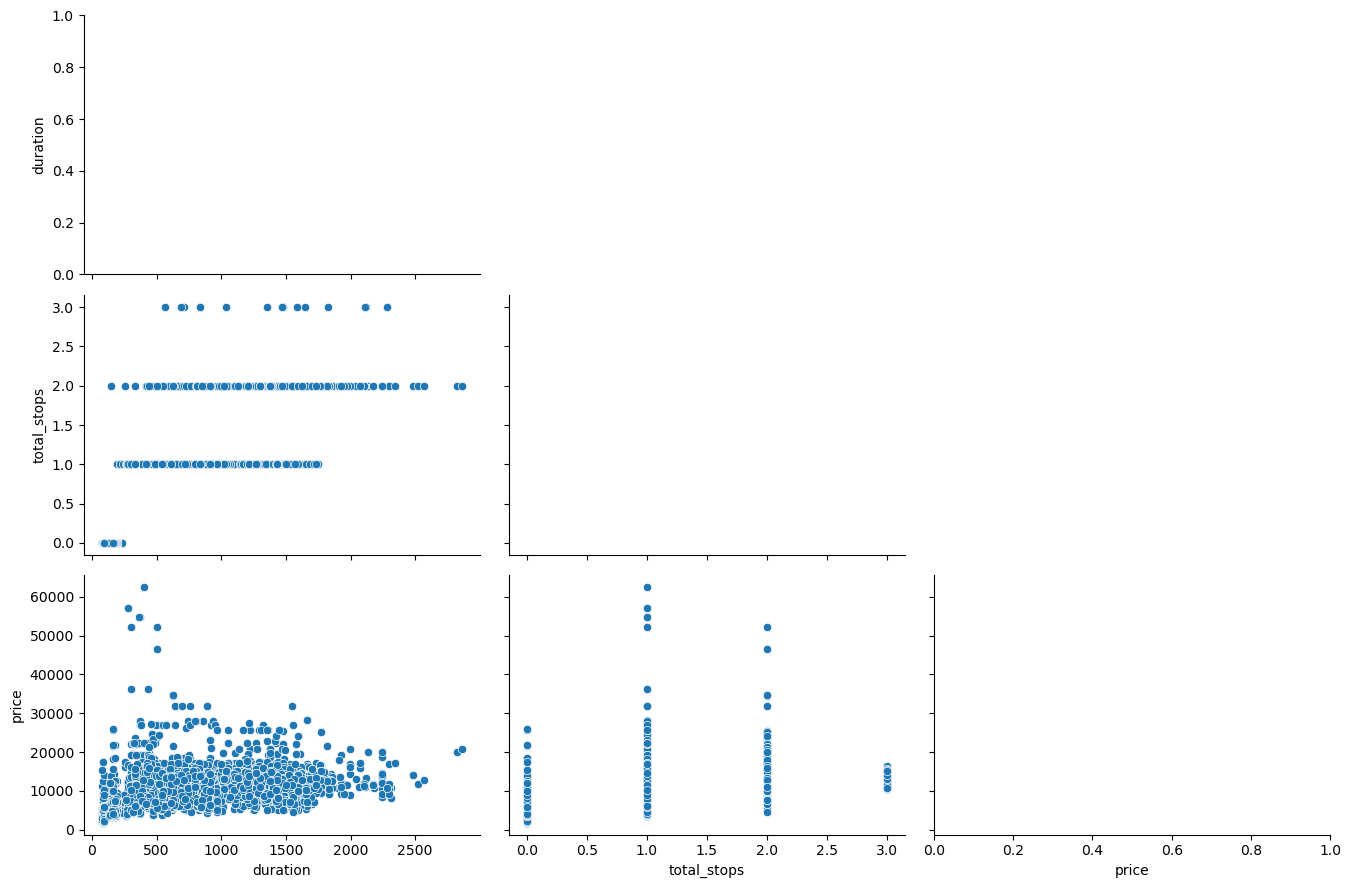

In [19]:
eda_helper_functions.pair_plots(train)

## 8. Correlation Analysis

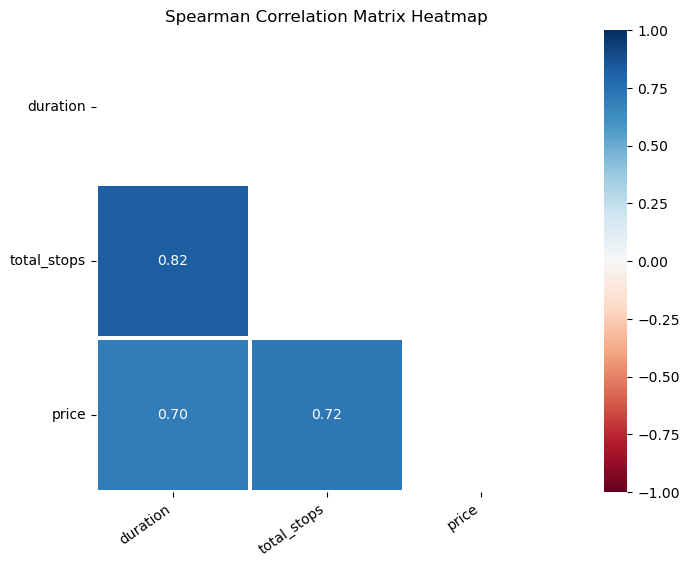

In [20]:
eda_helper_functions.correlation_heatmap(train) # Numerical features

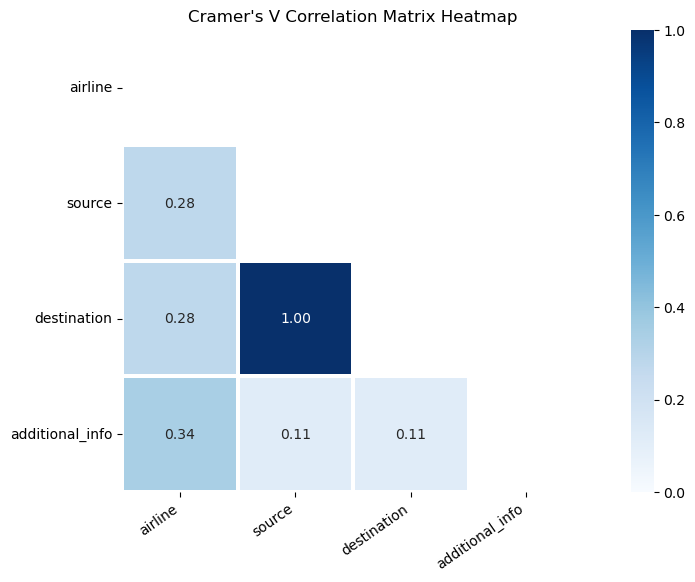

In [21]:
eda_helper_functions.cramersV_heatmap(train)  # Categorical features

## 9. Detailed Analysis

In [22]:
train.columns

Index(['airline', 'date_of_journey', 'source', 'destination', 'dep_time',
       'arrival_time', 'duration', 'total_stops', 'additional_info', 'price'],
      dtype='object')

### 9.1 airline

In [23]:
train.airline.unique()

array(['Jet Airways', 'Goair', 'Air India', 'Spicejet',
       'Multiple Carriers', 'Indigo', 'Vistara', 'Air Asia', 'Trujet'],
      dtype=object)

In [24]:
train.airline.value_counts()

Jet Airways          2391
Indigo               1296
Air India            1075
Multiple Carriers     736
Spicejet              537
Vistara               322
Air Asia              211
Goair                 125
Trujet                  1
Name: airline, dtype: int64

In [25]:
train.airline.value_counts(normalize=True)

Jet Airways          0.357186
Indigo               0.193606
Air India            0.160592
Multiple Carriers    0.109949
Spicejet             0.080221
Vistara              0.048103
Air Asia             0.031521
Goair                0.018673
Trujet               0.000149
Name: airline, dtype: float64

In [26]:
eda_helper_functions.cat_summary(train, "airline")

0       Jet Airways
1       Jet Airways
2             Goair
3         Air India
4       Jet Airways
           ...     
6690    Jet Airways
6691      Air India
6692    Jet Airways
6693       Air Asia
6694      Air India
Name: airline, Length: 6694, dtype: object

Data Type      : object
Cardinality    : 9 categories
Missing Data   : 0 rows (0.00 %)
Available Data : 6,694 / 6,694 rows


,
count,6694
unique,9
top,Jet Airways
freq,2391


,count,percentage
category,,
Jet Airways,2391,0.357186
Indigo,1296,0.193606
Air India,1075,0.160592
Multiple Carriers,736,0.109949
Spicejet,537,0.080221
Vistara,322,0.048103
Air Asia,211,0.031521
Goair,125,0.018673
Trujet,1,0.000149


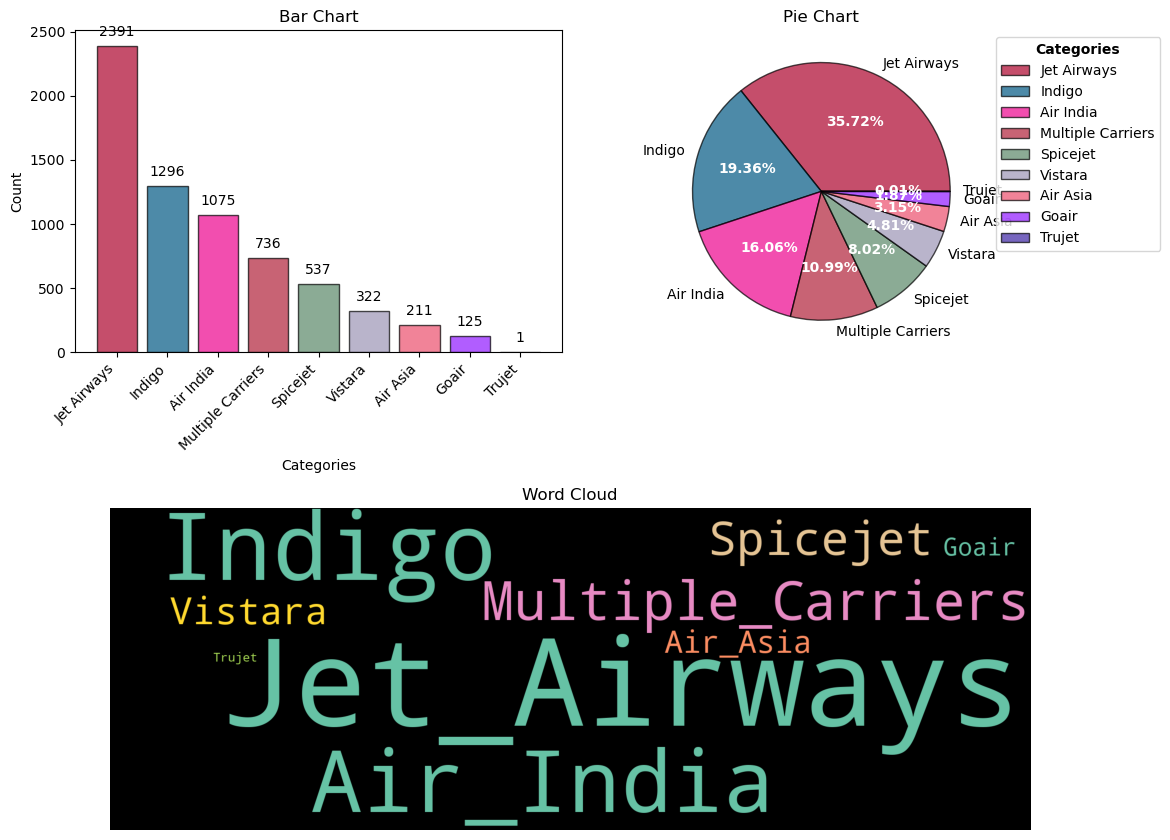

In [27]:
eda_helper_functions.cat_univar_plots(train, "airline", )

- There are 5 airlies which have less than 10% share

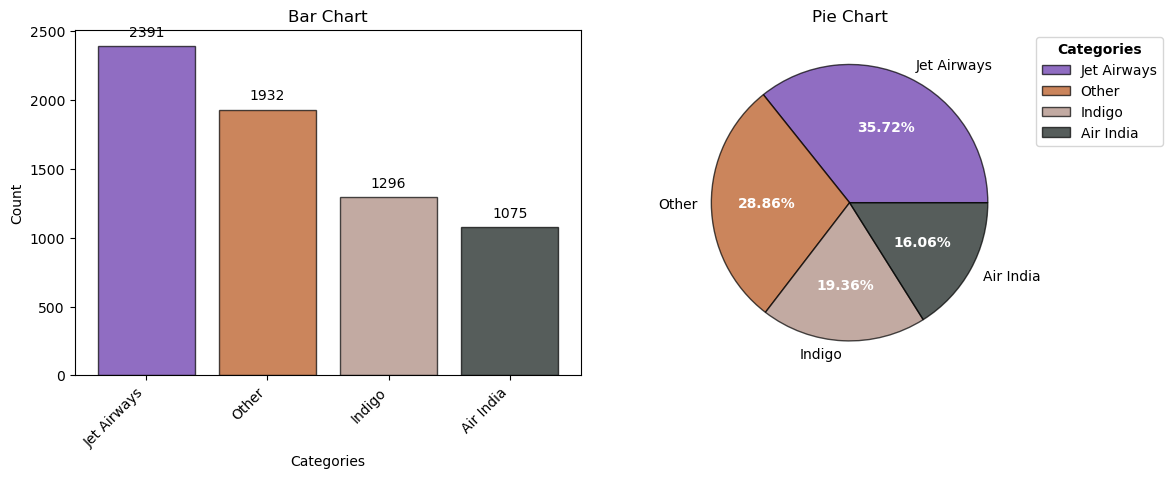

In [28]:
eda_helper_functions.cat_univar_plots(train, "airline", show_wordcloud=False, k=3)

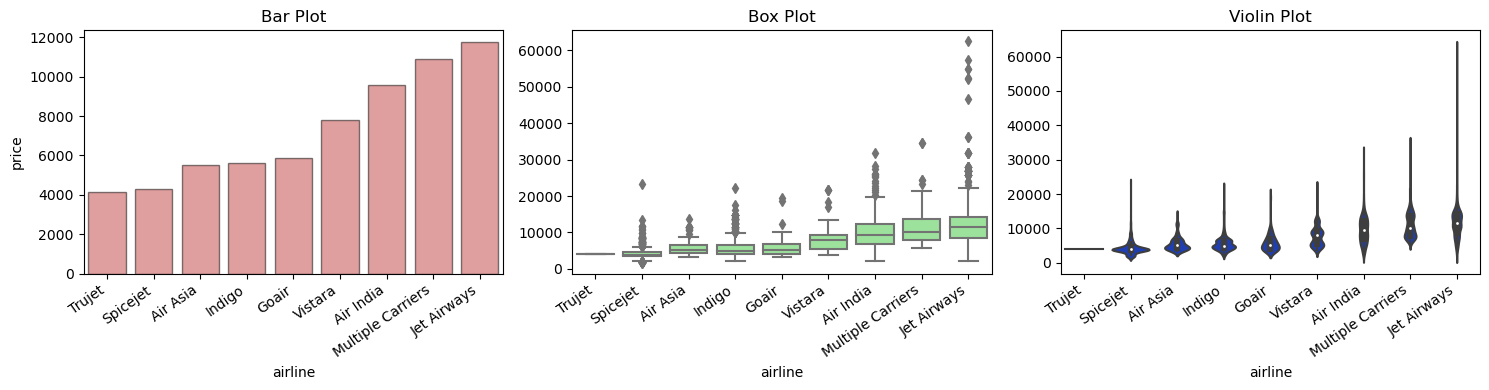

In [29]:
eda_helper_functions.num_cat_bivar_plots(
	data=train,
	num_var="price",
	cat_var="airline"
)

- We can clearly observe that Airline has an impact on price

In [30]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6694 entries, 0 to 6694
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   airline          6694 non-null   object        
 1   date_of_journey  6694 non-null   datetime64[ns]
 2   source           6694 non-null   object        
 3   destination      6694 non-null   object        
 4   dep_time         6694 non-null   datetime64[ns]
 5   arrival_time     6694 non-null   datetime64[ns]
 6   duration         6694 non-null   int64         
 7   total_stops      6694 non-null   float64       
 8   additional_info  6694 non-null   object        
 9   price            6694 non-null   int64         
dtypes: datetime64[ns](3), float64(1), int64(2), object(4)
memory usage: 575.3+ KB


### 9.2 source

In [31]:
eda_helper_functions.cat_summary(train, 'source')

0       Banglore
1          Delhi
2       Banglore
3        Kolkata
4       Banglore
          ...   
6690       Delhi
6691     Kolkata
6692       Delhi
6693       Delhi
6694    Banglore
Name: source, Length: 6694, dtype: object

Data Type      : object
Cardinality    : 5 categories
Missing Data   : 0 rows (0.00 %)
Available Data : 6,694 / 6,694 rows


,
count,6694
unique,5
top,Delhi
freq,2729


,count,percentage
category,,
Delhi,2729,0.407679
Kolkata,1842,0.275172
Banglore,1435,0.214371
Mumbai,448,0.066926
Chennai,240,0.035853


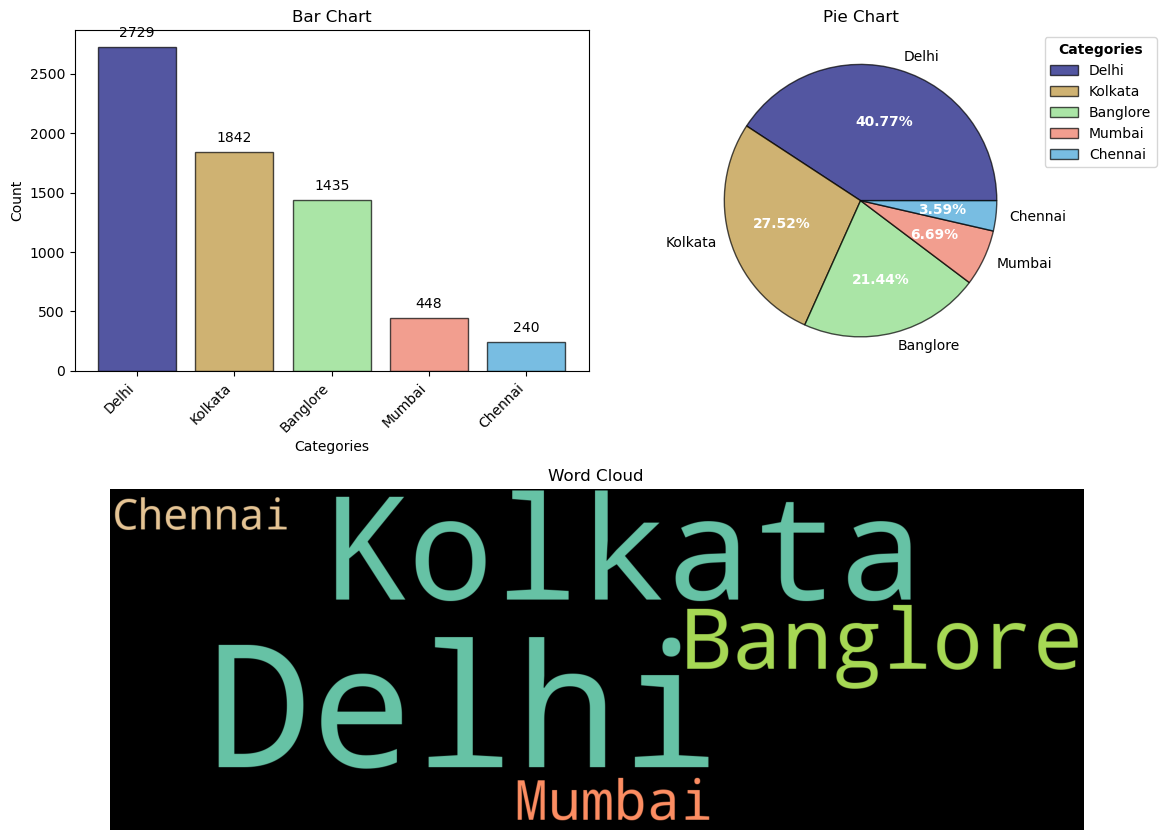

In [32]:
eda_helper_functions.cat_univar_plots(train, 'source')

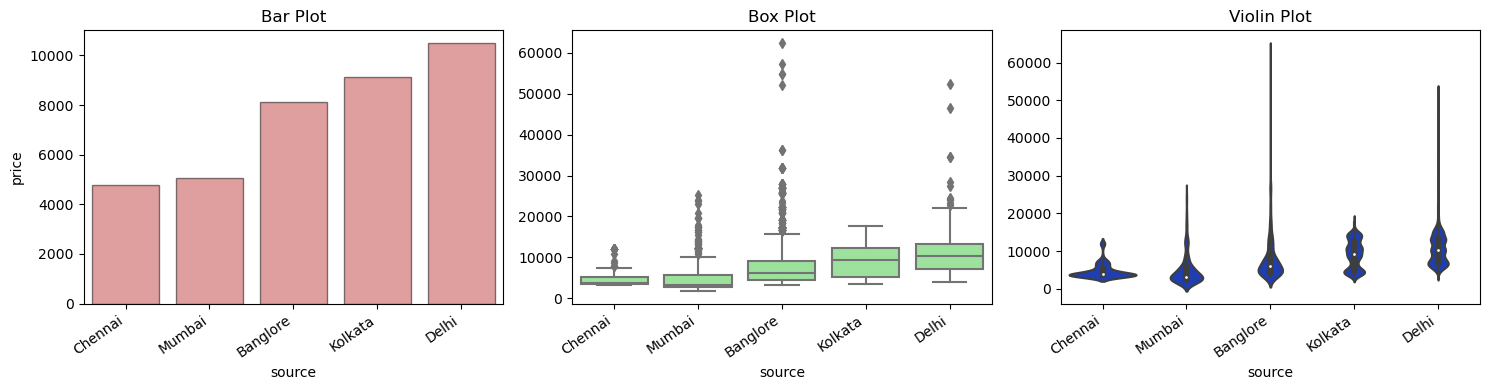

In [33]:
eda_helper_functions.num_cat_bivar_plots(
	data=train,
	num_var="price",
	cat_var="source"
)

### 9.3 destination

In [34]:
eda_helper_functions.cat_summary(train,'destination')

0          Delhi
1         Cochin
2          Delhi
3       Banglore
4          Delhi
          ...   
6690      Cochin
6691    Banglore
6692      Cochin
6693      Cochin
6694       Delhi
Name: destination, Length: 6694, dtype: object

Data Type      : object
Cardinality    : 5 categories
Missing Data   : 0 rows (0.00 %)
Available Data : 6,694 / 6,694 rows


,
count,6694
unique,5
top,Cochin
freq,2729


,count,percentage
category,,
Cochin,2729,0.407679
Banglore,1842,0.275172
Delhi,1435,0.214371
Hyderabad,448,0.066926
Kolkata,240,0.035853


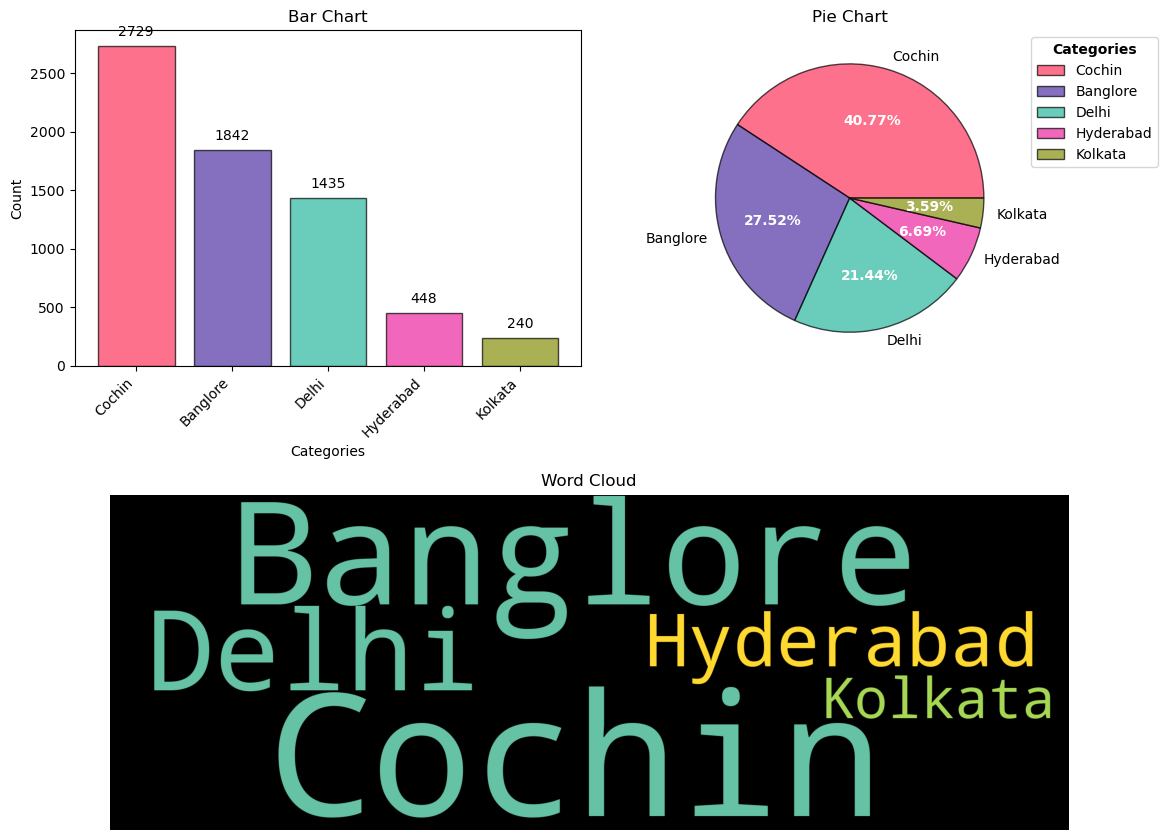

In [35]:
eda_helper_functions.cat_univar_plots(train, 'destination')

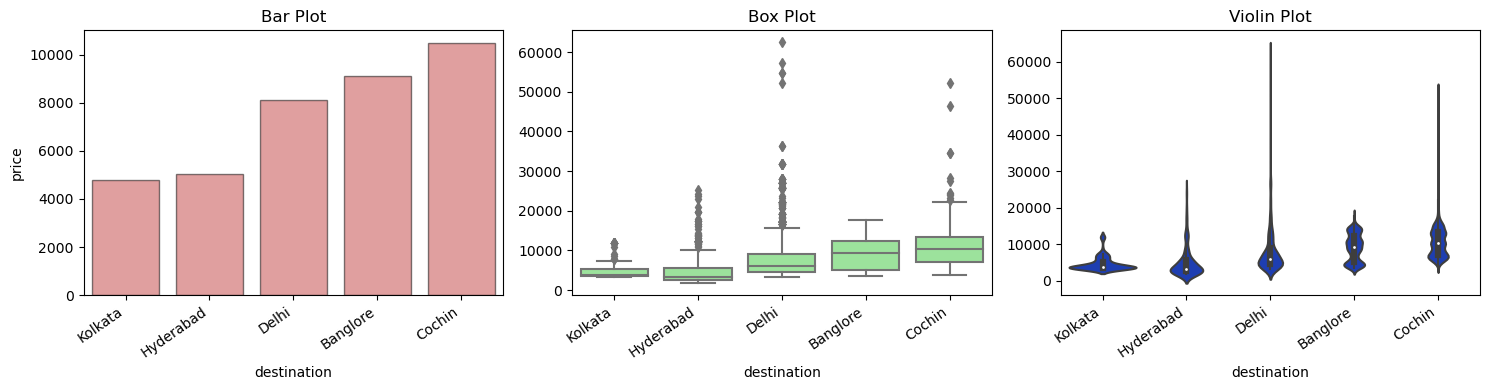

In [36]:
eda_helper_functions.num_cat_bivar_plots(
	data=train,
	num_var="price",
	cat_var="destination"
)

### 9.4 additional_info

In [37]:
eda_helper_functions.cat_summary(train, 'additional_info')

0       In-flight meal not included
1       In-flight meal not included
2                           No Info
3                           No Info
4       In-flight meal not included
                   ...             
6690                        No Info
6691                        No Info
6692    In-flight meal not included
6693                        No Info
6694                 1 Long layover
Name: additional_info, Length: 6694, dtype: object

Data Type      : object
Cardinality    : 7 categories
Missing Data   : 0 rows (0.00 %)
Available Data : 6,694 / 6,694 rows


,
count,6694
unique,7
top,No Info
freq,5248


,count,percentage
category,,
No Info,5248,0.783986
In-flight meal not included,1215,0.181506
No check-in baggage included,207,0.030923
1 Long layover,16,0.002390
Change airports,5,0.000747
Business class,2,0.000299
Red-eye flight,1,0.000149


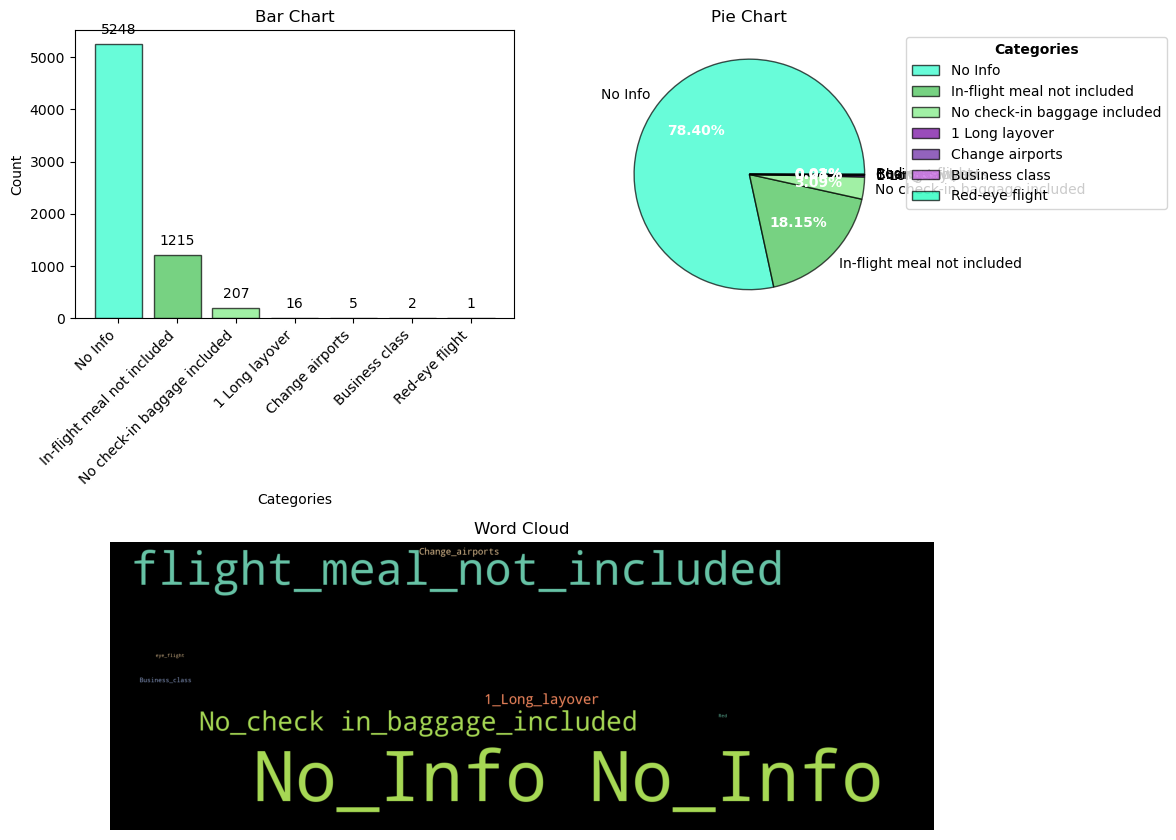

In [38]:
eda_helper_functions.cat_univar_plots(train, 'additional_info')

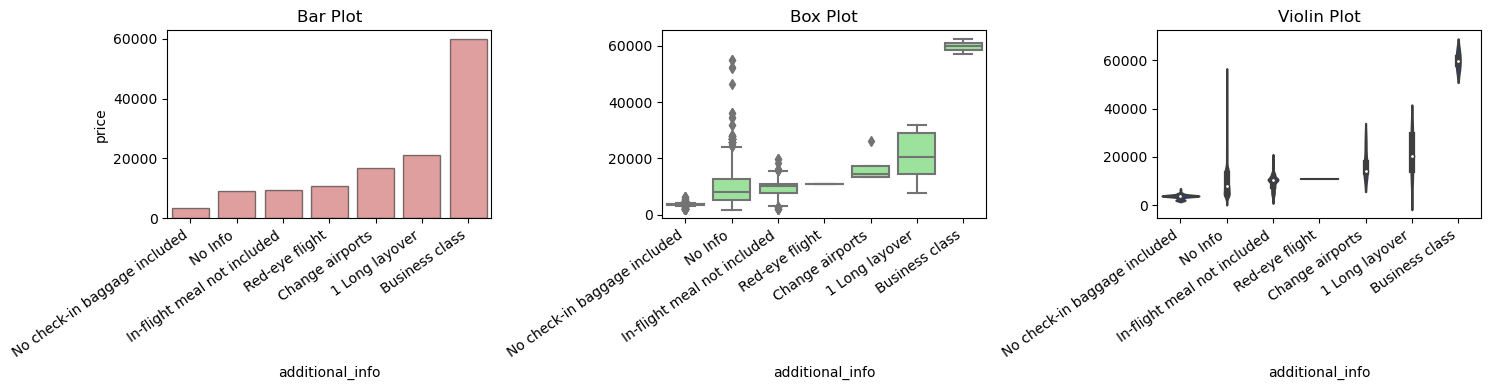

In [39]:
eda_helper_functions.num_cat_bivar_plots(
	data=train,
	num_var="price",
	cat_var="additional_info"
)

### 9.5 Hypothesis Testing (Cat feature Vs Numerical Target)

In [40]:
eda_helper_functions.num_cat_hyp_testing(train, "price", "airline")

- Significance Level   : 5.0%
- Null Hypothesis      : The groups have similar population mean
- Alternate Hypothesis : The groups don't have similar population mean
- Test Statistic       : 473.2504388077414
- p-value              : 0.0
- Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: The variables price and airline are associated to each other


- Significance Level   : 5.0%
- Null Hypothesis      : The groups have similar population median
- Alternate Hypothesis : The groups don't have similar population median
- Test Statistic       : 3130.947388921903
- p-value              : 0.0
- Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: The variables price and airline are associated to each other


In [41]:
eda_helper_functions.num_cat_hyp_testing(train, "price", "source")

- Significance Level   : 5.0%
- Null Hypothesis      : The groups have similar population mean
- Alternate Hypothesis : The groups don't have similar population mean
- Test Statistic       : 244.58028823589046
- p-value              : 2.2961644028308123e-196
- Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: The variables price and source are associated to each other


- Significance Level   : 5.0%
- Null Hypothesis      : The groups have similar population median
- Alternate Hypothesis : The groups don't have similar population median
- Test Statistic       : 1425.4683818353044
- p-value              : 2.074962835494992e-307
- Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: The variables price and source are associated to each other


In [42]:
eda_helper_functions.num_cat_hyp_testing(train, "price", "destination")

- Significance Level   : 5.0%
- Null Hypothesis      : The groups have similar population mean
- Alternate Hypothesis : The groups don't have similar population mean
- Test Statistic       : 244.58028823589046
- p-value              : 2.2961644028308123e-196
- Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: The variables price and destination are associated to each other


- Significance Level   : 5.0%
- Null Hypothesis      : The groups have similar population median
- Alternate Hypothesis : The groups don't have similar population median
- Test Statistic       : 1425.4683818353008
- p-value              : 2.0749628354987715e-307
- Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: The variables price and destination are associated to each other


In [43]:
eda_helper_functions.num_cat_hyp_testing(train, "price", "additional_info")

- Significance Level   : 5.0%
- Null Hypothesis      : The groups have similar population mean
- Alternate Hypothesis : The groups don't have similar population mean
- Test Statistic       : 121.29226780051071
- p-value              : 5.326678075216221e-146
- Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: The variables price and additional_info are associated to each other


- Significance Level   : 5.0%
- Null Hypothesis      : The groups have similar population median
- Alternate Hypothesis : The groups don't have similar population median
- Test Statistic       : 541.8032806818912
- p-value              : 8.254903397053232e-114
- Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: The variables price and additional_info are associated to each other


### 9.6 date_of_journey

In [44]:
train.date_of_journey

0      2019-03-21
1      2019-03-27
2      2019-03-09
3      2019-06-12
4      2019-03-12
          ...    
6690   2019-03-21
6691   2019-05-01
6692   2019-06-01
6693   2019-06-24
6694   2019-03-01
Name: date_of_journey, Length: 6694, dtype: datetime64[ns]

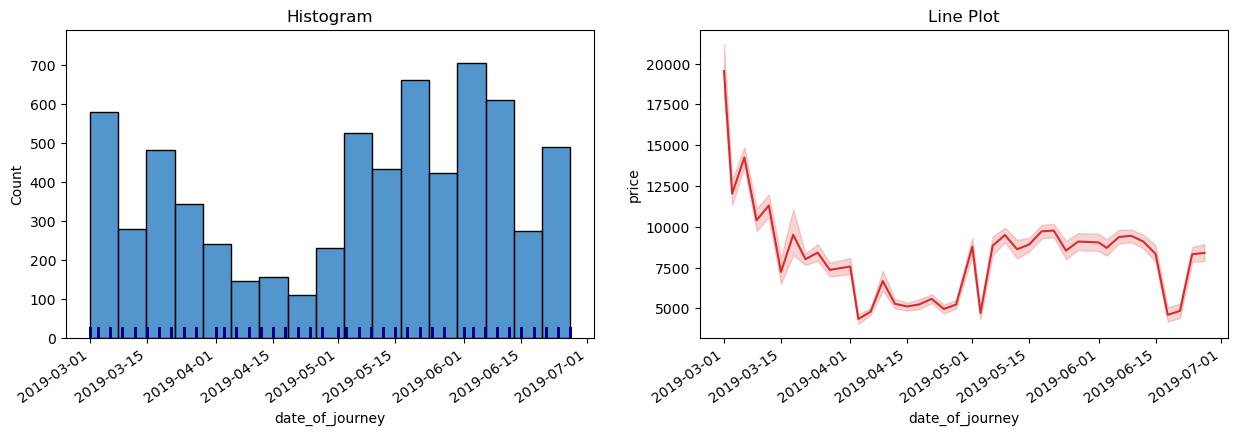

In [45]:
eda_helper_functions.dt_univar_plots(
	data=train,
	var="date_of_journey",
	target="price"
)

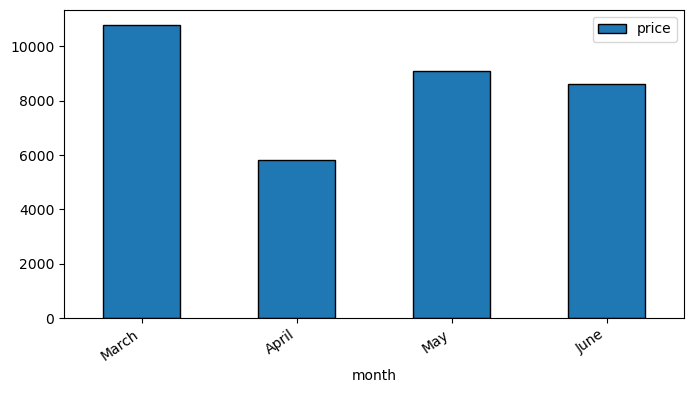

In [46]:
(
	train
	.groupby(pd.Grouper(key="date_of_journey", freq="M"))
	.price.mean()
	.to_frame()
	.set_axis(["March", "April", "May", "June"], axis=0)
	.rename_axis(index="month")
	.plot(
		kind="bar",
		figsize=(8, 4),
		edgecolor="black"
	)
)

ax = plt.gca()
eda_helper_functions.rotate_xlabels(ax)

In [47]:
(
	train
	.groupby(pd.Grouper(key="date_of_journey", freq="M")) # Frequency Month
	.price.mean()
	.to_frame()
	.set_axis(["March", "April", "May", "June"], axis=0)
	.rename_axis(index="month")
# # 	.plot(
# # 		kind="bar",
# # 		figsize=(8, 4),
# # 		edgecolor="black"
# 	)
)

,price
month,
March,10808.167558
April,5827.549790
May,9091.195309
June,8627.806824


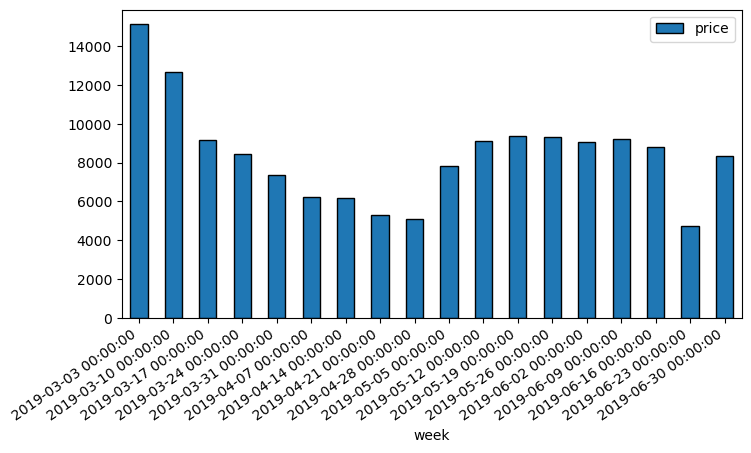

In [48]:
(
	train
	.groupby(pd.Grouper(key="date_of_journey", freq="W"))  # Frequency Week
	.price.mean()
	.to_frame()
	.rename_axis(index="week")
	.plot(
		kind="bar",
		figsize=(8, 4),
		edgecolor="black"
	)
)

ax = plt.gca()
eda_helper_functions.rotate_xlabels(ax)

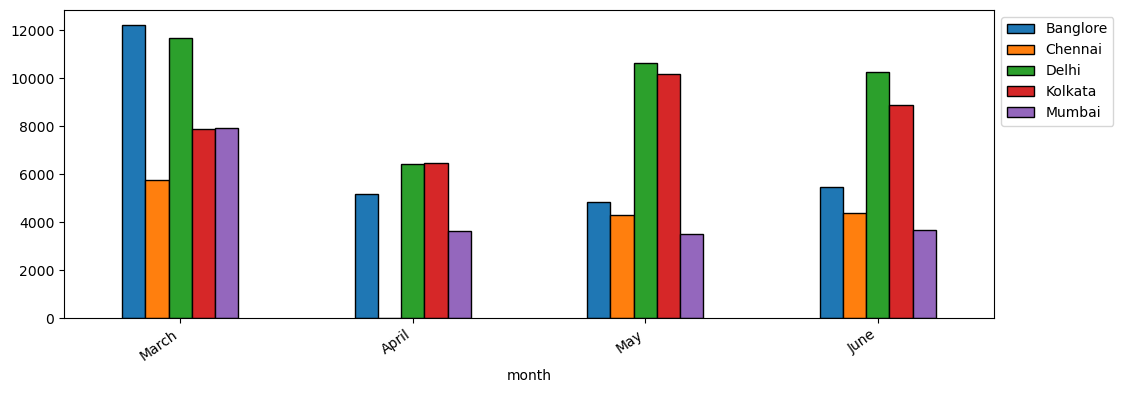

In [49]:
(
	train
	.groupby([pd.Grouper(key="date_of_journey", freq="M"), "source"])
	.price.mean()
	.unstack(fill_value=0)
	.set_axis(["March", "April", "May", "June"], axis=0)
	.rename_axis(index="month")
	.plot(
		kind="bar",
		figsize=(12, 4),
		edgecolor="black"
	)
)

ax = plt.gca()

ax.legend(
	loc="upper left",
	bbox_to_anchor=(1, 1)
)

eda_helper_functions.rotate_xlabels(ax)

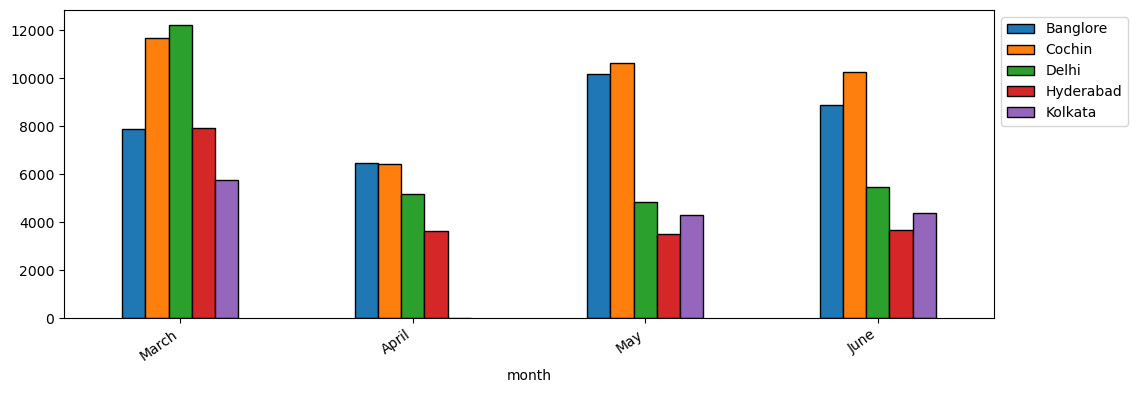

In [50]:
(
	train
	.groupby([pd.Grouper(key="date_of_journey", freq="M"), "destination"])
	.price.mean()
	.unstack(fill_value=0)
	.set_axis(["March", "April", "May", "June"], axis=0)
	.rename_axis(index="month")
	.plot(
		kind="bar",
		figsize=(12, 4),
		edgecolor="black"
	)
)

ax = plt.gca()

ax.legend(
	loc="upper left",
	bbox_to_anchor=(1, 1)
)

eda_helper_functions.rotate_xlabels(ax)

### 9.7 dep_time

In [51]:
train.dep_time

0      2024-06-10 08:55:00
1      2024-06-10 17:30:00
2      2024-06-10 11:40:00
3      2024-06-10 09:25:00
4      2024-06-10 22:55:00
               ...        
6690   2024-06-10 10:45:00
6691   2024-06-10 09:25:00
6692   2024-06-10 14:00:00
6693   2024-06-10 07:55:00
6694   2024-06-10 11:50:00
Name: dep_time, Length: 6694, dtype: datetime64[ns]

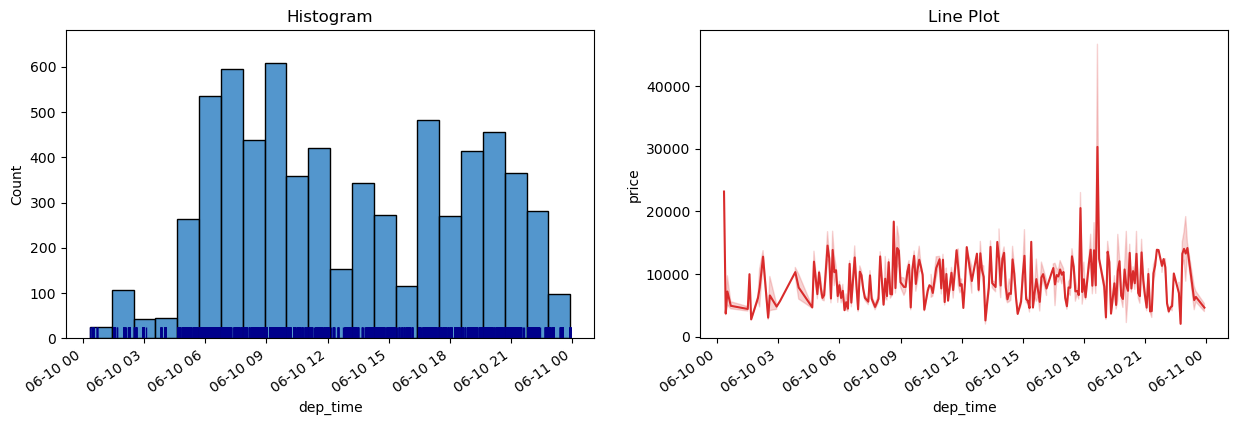

In [52]:
eda_helper_functions.dt_univar_plots(train, "dep_time", "price")

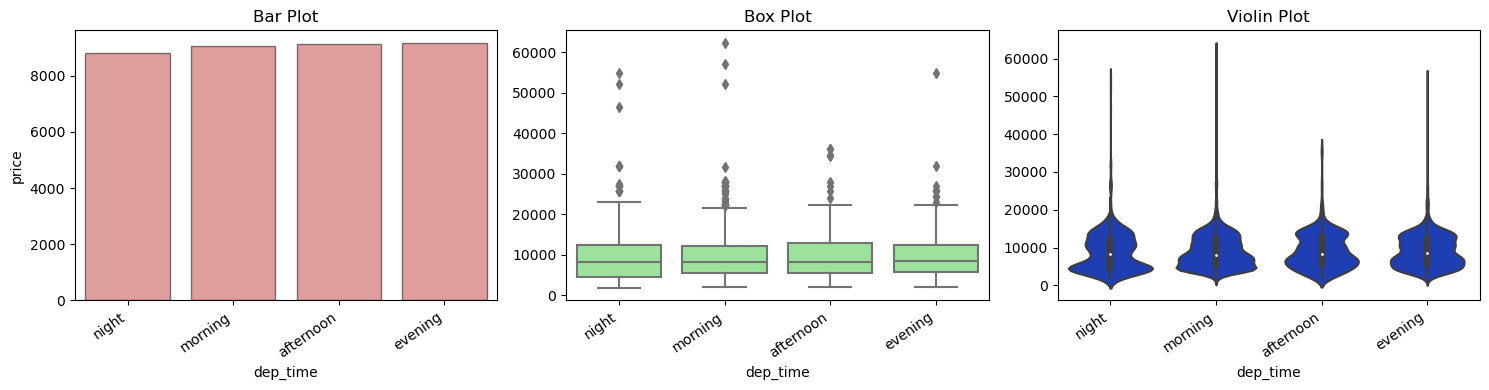

In [53]:
# Flights time of the day Vs Price
(
	train
	.assign(dep_time=lambda df_: (
		np.select([df_.dep_time.dt.hour.between(4, 12, inclusive="left"),
				   df_.dep_time.dt.hour.between(12, 16, inclusive="left"),
				   df_.dep_time.dt.hour.between(16, 20, inclusive="left")],
				  ["morning", "afternoon", "evening"],
				  default="night")
	))
	.pipe(eda_helper_functions.num_cat_bivar_plots, "price", "dep_time")
)

### 9.8 duration

In [54]:
train.duration

0        615
1        655
2        175
3        545
4        525
        ... 
6690    1925
6691     545
6692     300
6693     330
6694    1265
Name: duration, Length: 6694, dtype: int64

In [56]:
eda_helper_functions.num_summary(train, 'duration')

0        615
1        655
2        175
3        545
4        525
        ... 
6690    1925
6691     545
6692     300
6693     330
6694    1265
Name: duration, Length: 6694, dtype: int64

Data Type      : int64
Missing Data   : 0 rows (0.00 %)
Available Data : 6,694 / 6,694 rows


,value
percentile,
0,75.00
5,90.00
10,145.00
25,170.00
50,510.00
75,920.00
90,1440.00
95,1601.75
99,1855.00


,value
mean,633.371676
trimmed mean (5%),599.575174
trimmed mean (10%),570.895258
median,510.000000


,value
var,252960.712875
std,502.951999
IQR,750.000000
mad,340.000000
coef_variance,0.794087


,value
skewness,0.894131
kurtosis,-0.052204


Significance Level   : 0.05
Null Hypothesis      : The data is normally distributed
Alternate Hypothesis : The data is not normally distributed
p-value              : 0.0
Test Statistic       : 0.8865419626235962
- Since p-value is less than alpha (0.05), we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: We conclude that the data sample is not normally distributed


Significance Level   : 0.05
Null Hypothesis      : The data is normally distributed
Alternate Hypothesis : The data is not normally distributed
Critical Value       : 0.787
Test Statistic       : 248.45769626661695
- Since the Test-statistic is greater than Critical Value, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: We conclude that the data sample is not normally distributed


- duration data is not normally distributed

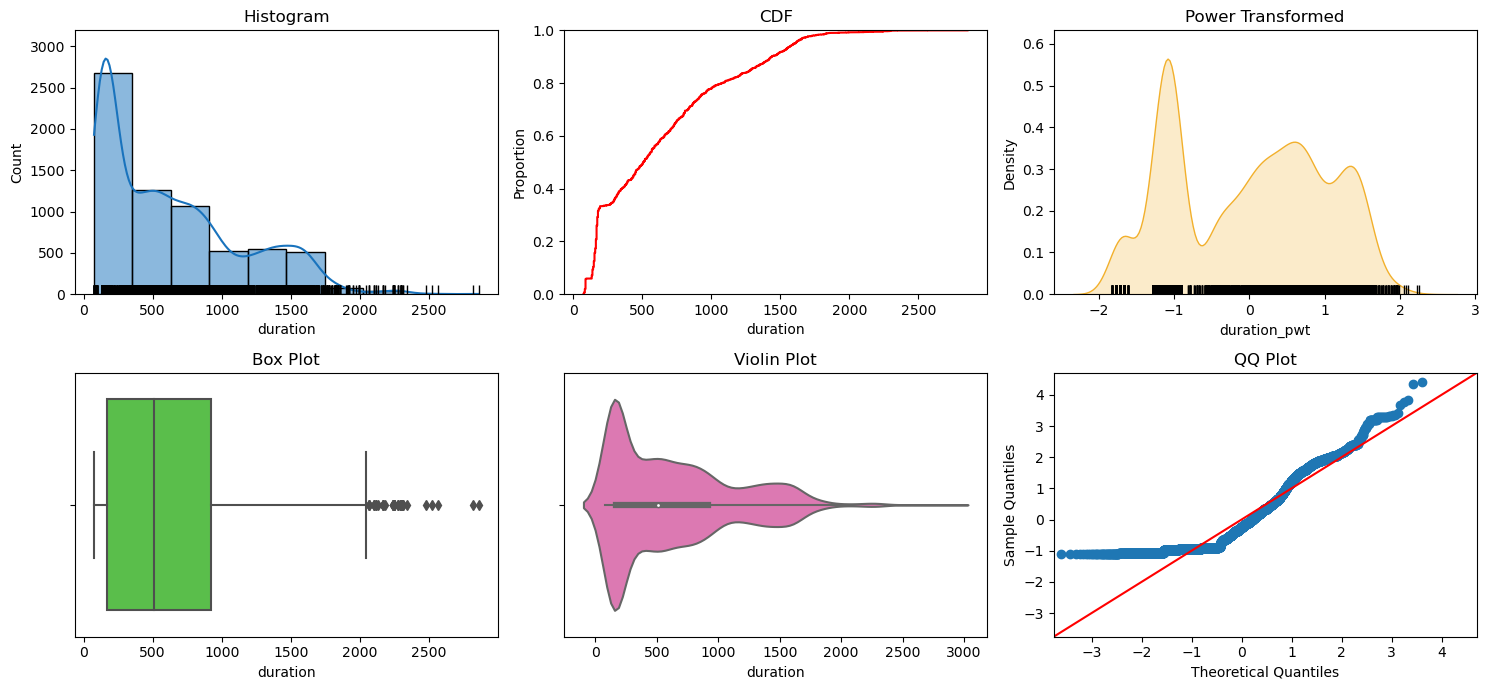

In [57]:
eda_helper_functions.num_univar_plots(train,'duration')

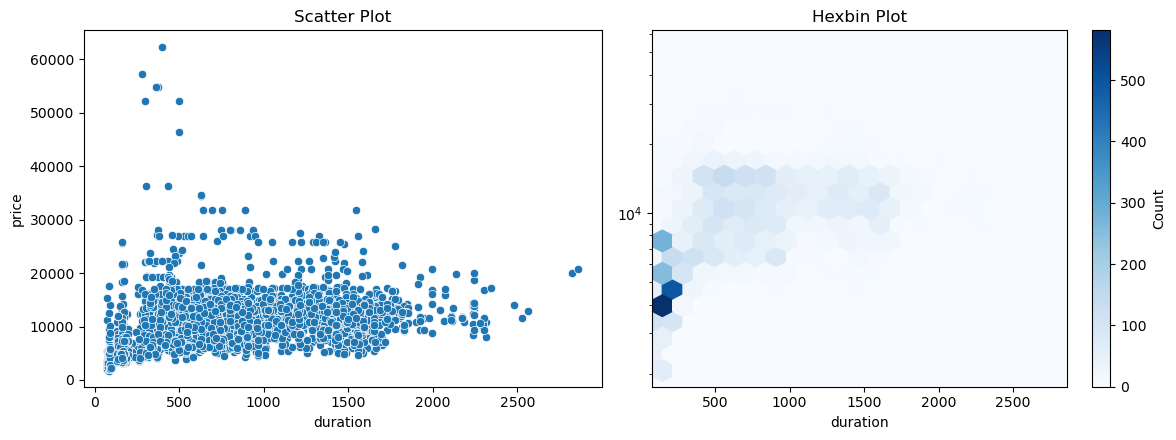

In [58]:
eda_helper_functions.num_bivar_plots(
	train,
	"duration",
	"price",
	hexbin_kwargs=dict(
		yscale="log",
		gridsize=20,
		cmap="Blues"
	)
)

In [59]:
eda_helper_functions.num_num_hyp_testing(train, "price", "duration")

- Significance Level   : 5.0%
- Null Hypothesis      : The samples are uncorrelated
- Alternate Hypothesis : The samples are correlated
- Test Statistic       : 0.5091878071906606
- p-value              : 0.0
- Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: The variables price and duration are correlated


- Significance Level   : 5.0%
- Null Hypothesis      : The samples are uncorrelated
- Alternate Hypothesis : The samples are correlated
- Test Statistic       : 0.6980000420004595
- p-value              : 0.0
- Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: The variables price and duration are correlated


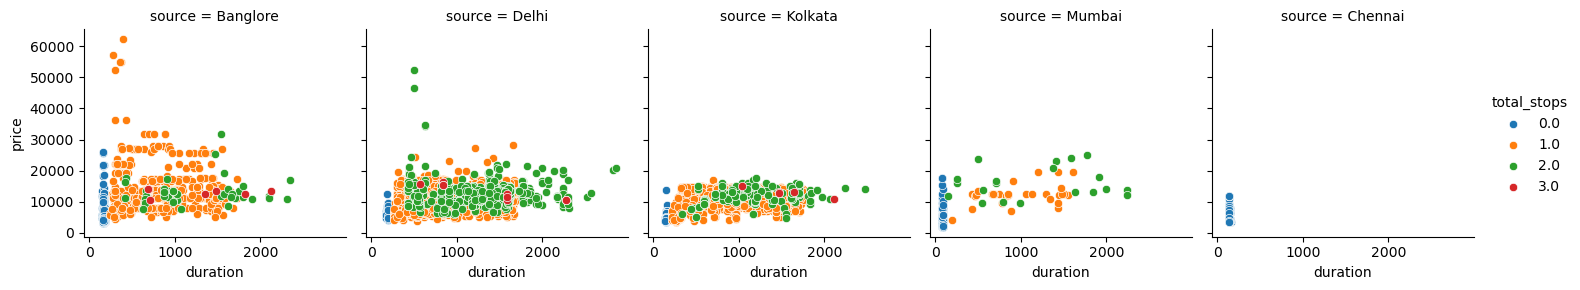

In [60]:
duration_grid = sns.FacetGrid(
	data=train,
	col="source",
	hue="total_stops",
	sharey=True
)

duration_grid.map(sns.scatterplot, "duration", "price")

duration_grid.add_legend()

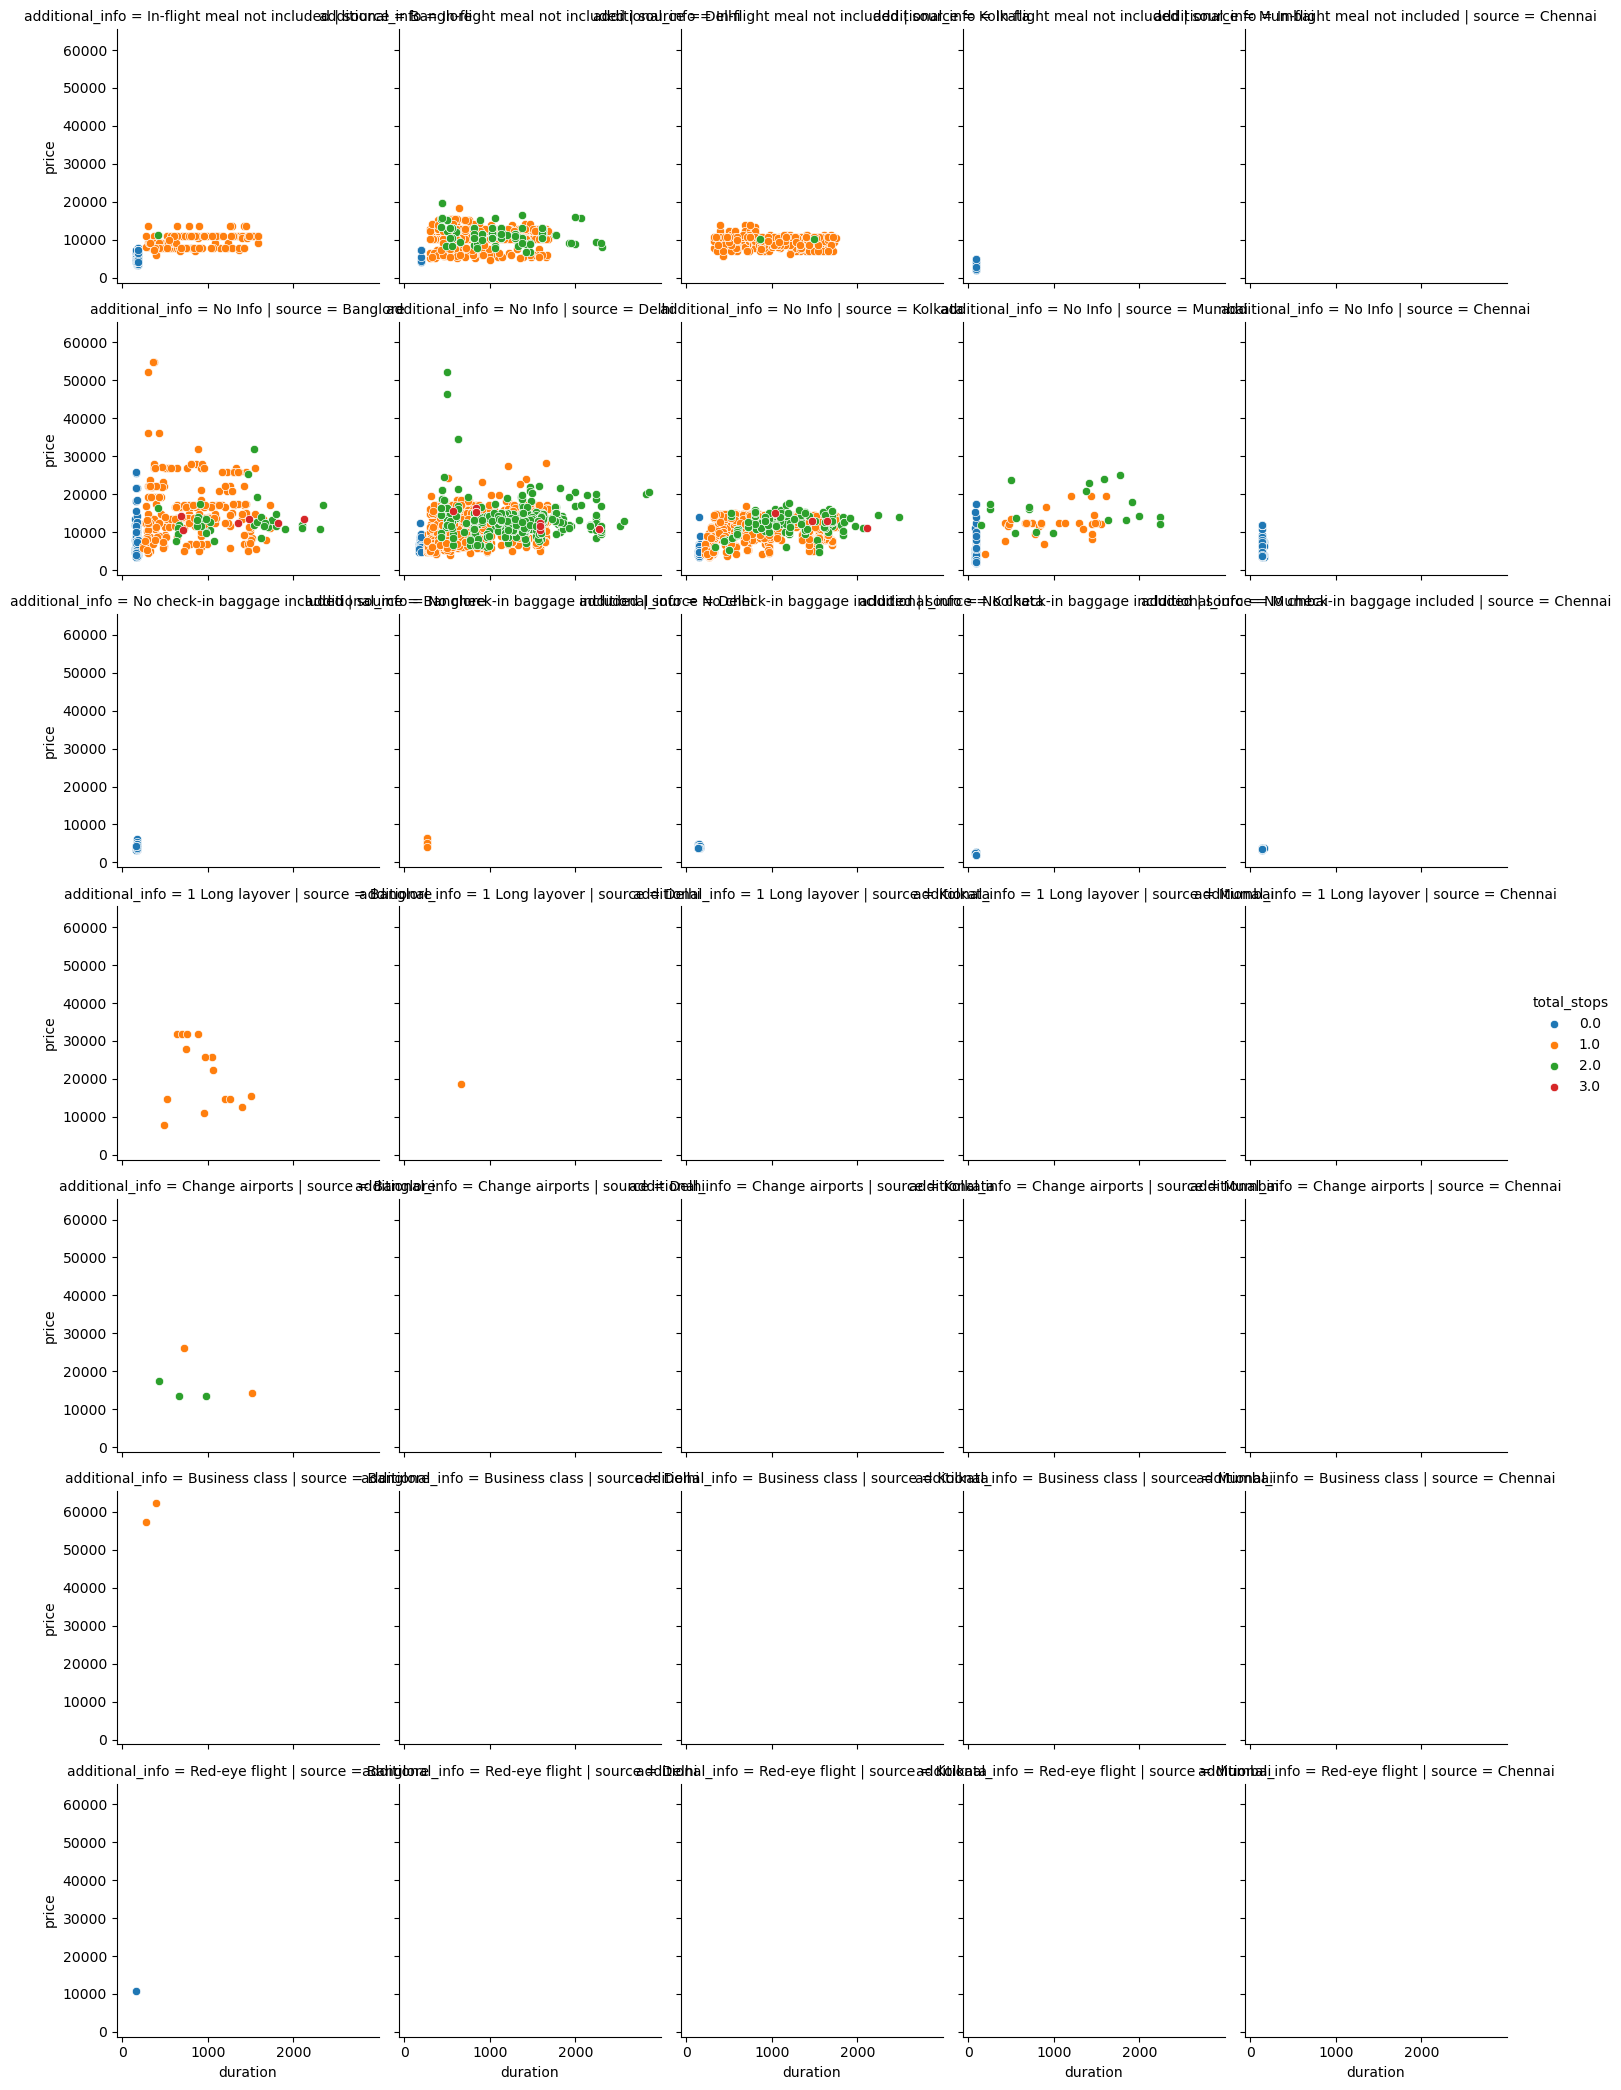

In [61]:
duration_grid = sns.FacetGrid(
	data=train,
	col="source",
	row="additional_info",
	hue="total_stops",
	sharey=True
)

duration_grid.map(sns.scatterplot, "duration", "price")

duration_grid.add_legend()

In [62]:
eda_helper_functions.get_iqr_outliers(train, "duration")
# Lot of outliers in duration column

Lower Limit : -955.0
Upper Limit : 2045.0


,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
3690,Air India,2019-05-01,Kolkata,Banglore,2024-06-10 05:50:00,2024-06-10 16:15:00,2065,2.0,No Info,10991
6079,Jet Airways,2019-03-06,Delhi,Cochin,2024-06-10 17:55:00,2024-06-10 04:25:00,2070,2.0,No Info,17072
3225,Jet Airways,2019-03-06,Delhi,Cochin,2024-06-10 17:55:00,2024-06-10 04:25:00,2070,2.0,In-flight meal not included,15812
2990,Air India,2019-03-03,Banglore,Delhi,2024-06-10 11:05:00,2024-06-10 22:10:00,2105,2.0,No Info,11791
4589,Air India,2019-03-18,Banglore,Delhi,2024-06-10 11:05:00,2024-06-10 22:10:00,2105,2.0,No Info,11161
1517,Air India,2019-03-03,Banglore,Delhi,2024-06-10 11:05:00,2024-06-10 22:10:00,2105,2.0,No Info,11948
2916,Air India,2019-05-12,Kolkata,Banglore,2024-06-10 12:00:00,2024-06-10 23:15:00,2115,3.0,No Info,10991
2170,Air India,2019-03-12,Banglore,Delhi,2024-06-10 06:45:00,2024-06-10 18:05:00,2120,3.0,No Info,13387
1105,Jet Airways,2019-03-06,Delhi,Cochin,2024-06-10 16:50:00,2024-06-10 04:25:00,2135,2.0,No Info,19907
4000,Air India,2019-03-06,Delhi,Cochin,2024-06-10 07:05:00,2024-06-10 19:15:00,2170,2.0,No Info,11552


### 9.9 additional_info

In [63]:
eda_helper_functions.cat_summary(train, "additional_info")

0       In-flight meal not included
1       In-flight meal not included
2                           No Info
3                           No Info
4       In-flight meal not included
                   ...             
6690                        No Info
6691                        No Info
6692    In-flight meal not included
6693                        No Info
6694                 1 Long layover
Name: additional_info, Length: 6694, dtype: object

Data Type      : object
Cardinality    : 7 categories
Missing Data   : 0 rows (0.00 %)
Available Data : 6,694 / 6,694 rows


,
count,6694
unique,7
top,No Info
freq,5248


,count,percentage
category,,
No Info,5248,0.783986
In-flight meal not included,1215,0.181506
No check-in baggage included,207,0.030923
1 Long layover,16,0.002390
Change airports,5,0.000747
Business class,2,0.000299
Red-eye flight,1,0.000149


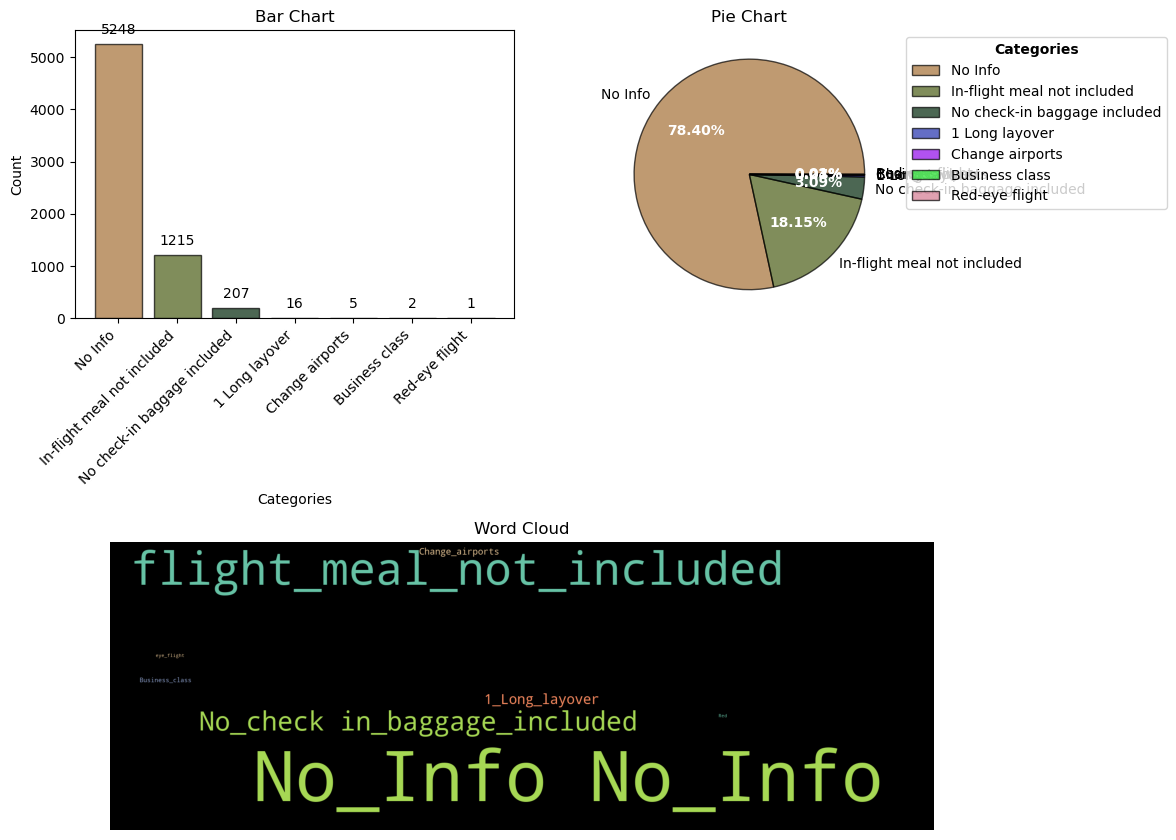

In [64]:
eda_helper_functions.cat_univar_plots(train, "additional_info")

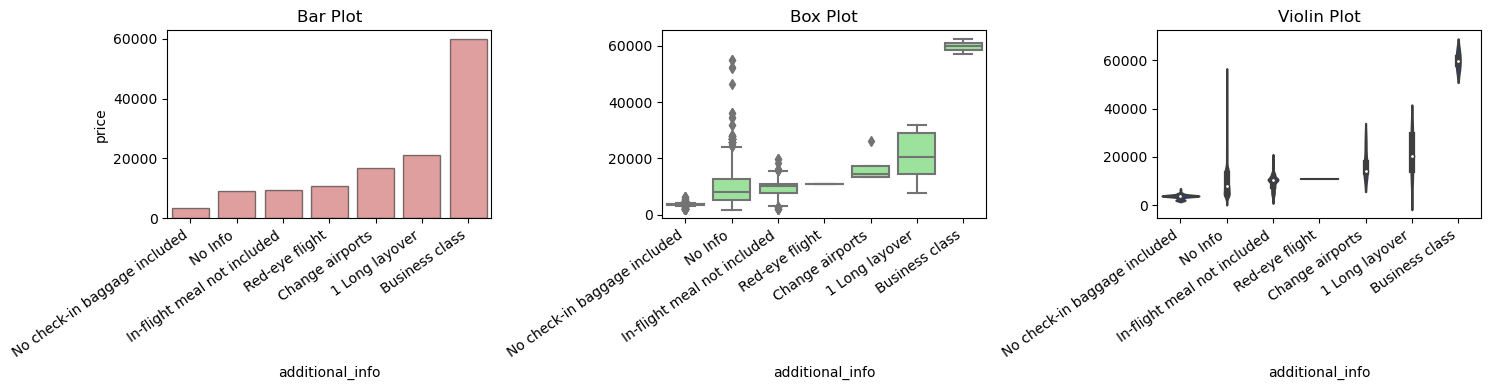

In [65]:
eda_helper_functions.num_cat_bivar_plots(train, "price", "additional_info")

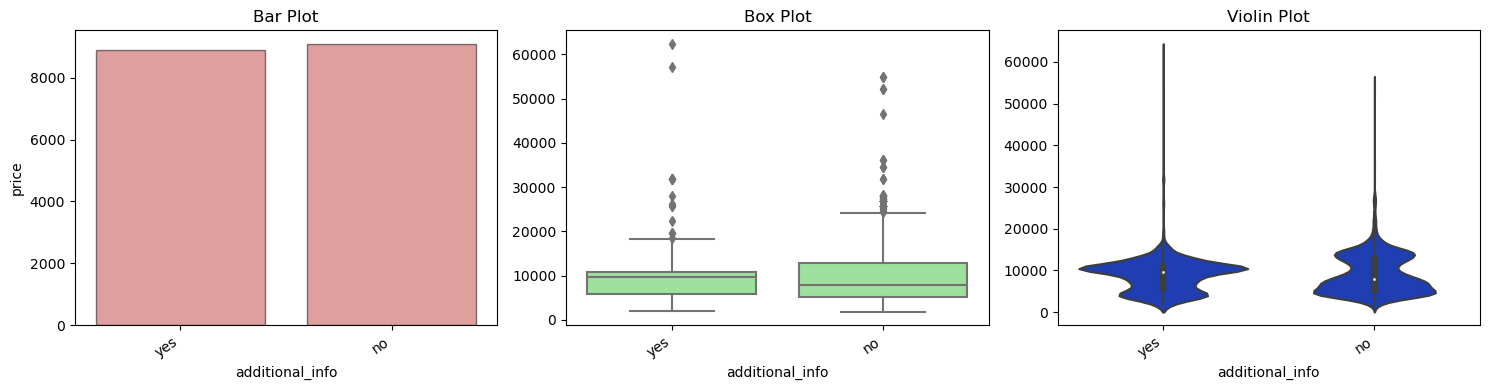

In [66]:
# converting additional_info into a binary feature for analysis (additional_info has severely rare categories)

(
	train
	.assign(additional_info=(
		train
		.additional_info
		.pipe(lambda ser: np.where(ser.eq("No Info"), "no", "yes"))
	))
	.pipe(eda_helper_functions.num_cat_bivar_plots, "price", "additional_info")
)

## 10. Automated EDA

In [68]:
!pip install sweetviz

Defaulting to user installation because normal site-packages is not writeable
                                              0.0/15.1 MB ? eta -:--:--
                                              0.1/15.1 MB ? eta -:--:--
                                              0.2/15.1 MB 3.1 MB/s eta 0:00:05
                                              0.3/15.1 MB 3.6 MB/s eta 0:00:05
     -                                        0.5/15.1 MB 3.6 MB/s eta 0:00:05
     -                                        0.5/15.1 MB 2.8 MB/s eta 0:00:06
     -                                        0.7/15.1 MB 3.1 MB/s eta 0:00:05
     --                                       1.1/15.1 MB 3.7 MB/s eta 0:00:04
     --                                       1.1/15.1 MB 3.6 MB/s eta 0:00:04
     ---                                      1.2/15.1 MB 3.4 MB/s eta 0:00:05
     ----                                     1.6/15.1 MB 3.8 MB/s eta 0:00:04
     ----                                     1.9/15.1 MB 4.0 MB/s 

In [69]:
# importing sweetviz
import sweetviz as sv
#analyzing the dataset
advert_report = sv.analyze(train)
#display the report
advert_report.show_html('flight-eda.html')

                                             |                                                                …

Report flight-eda.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [70]:
! pip install dtale

Defaulting to user installation because normal site-packages is not writeable
                                              0.0/14.3 MB ? eta -:--:--
                                             0.0/14.3 MB 991.0 kB/s eta 0:00:15
                                              0.2/14.3 MB 2.2 MB/s eta 0:00:07
                                              0.3/14.3 MB 2.5 MB/s eta 0:00:06
     -                                        0.4/14.3 MB 2.7 MB/s eta 0:00:06
     -                                        0.6/14.3 MB 2.5 MB/s eta 0:00:06
     -                                        0.7/14.3 MB 2.6 MB/s eta 0:00:06
     --                                       0.7/14.3 MB 2.4 MB/s eta 0:00:06
     --                                       1.0/14.3 MB 2.8 MB/s eta 0:00:05
     ---                                      1.1/14.3 MB 2.8 MB/s eta 0:00:05
     ---                                      1.4/14.3 MB 3.1 MB/s eta 0:00:05
     ----                                     1.6/14.3 MB 3

In [71]:
import dtale

In [72]:
dtale.show(data=train)

In [73]:
dtale.show(data=train, open_browser=True)

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6694 entries, 0 to 6694
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   airline          6694 non-null   object 
 1   date_of_journey  6694 non-null   object 
 2   source           6694 non-null   object 
 3   destination      6694 non-null   object 
 4   dep_time         6694 non-null   object 
 5   arrival_time     6694 non-null   object 
 6   duration         6694 non-null   int64  
 7   total_stops      6694 non-null   float64
 8   additional_info  6694 non-null   object 
 9   price            6694 non-null   int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 575.3+ KB


In [7]:
train.to_csv('E:\sagemaker-flight-prices-prediction\data\\train_final.csv', index=False)

In [9]:
pd.read_csv('E:\sagemaker-flight-prices-prediction\data\\train_final.csv').head(n=10)

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Jet Airways,2019-03-21,Banglore,Delhi,08:55:00,19:10:00,615,1.0,In-flight meal not included,7832
1,Jet Airways,2019-03-27,Delhi,Cochin,17:30:00,04:25:00,655,1.0,In-flight meal not included,6540
2,Goair,2019-03-09,Banglore,Delhi,11:40:00,14:35:00,175,0.0,No Info,7305
3,Air India,2019-06-12,Kolkata,Banglore,09:25:00,18:30:00,545,1.0,No Info,8366
4,Jet Airways,2019-03-12,Banglore,Delhi,22:55:00,07:40:00,525,1.0,In-flight meal not included,11087
5,Jet Airways,2019-04-21,Banglore,Delhi,18:55:00,22:00:00,185,0.0,In-flight meal not included,4544
6,Jet Airways,2019-04-01,Kolkata,Banglore,18:55:00,04:40:00,585,1.0,In-flight meal not included,7064
7,Spicejet,2019-06-15,Mumbai,Hyderabad,05:45:00,07:15:00,90,0.0,No check-in baggage included,2647
8,Multiple Carriers,2019-06-09,Delhi,Cochin,07:00:00,19:00:00,720,1.0,No Info,12192
9,Jet Airways,2019-05-09,Delhi,Cochin,23:05:00,04:25:00,1760,2.0,No Info,15129
